## Automated Hyperparameter optimisation

1. **Introduction** – Overview of Hyperparameter Optimization
2. **Data Preprocessing** – Loading and Cleaning Data
3. **Baseline Model** – Training a simple RandomForest model
4. **Manual Hyperparameter Tuning**
5. **Automated Hyperparameter Optimization** Techniques
    * **Grid Search**
    * **Randomized Search**
    * **Bayesian Optimization (Hyperopt)**
    * **Sequential Model-Based Optimization (Skopt)**
    * **Optuna**
    * **Genetic Algorithm (TPOT)**
6. **Conclusion** – Comparison of different methods

### Introduction

Hyperparameter optimization is the process of finding the best set of hyperparameters for a machine learning model. Instead of manually tuning parameters, we use optimization techniques like Grid Search, Random Search, Bayesian Optimization, and Genetic Algorithms to find the best parameters efficiently.

In this notebook, we will compare different hyperparameter tuning methods using a RandomForest classifier on the Diabetes dataset.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import fmin, tpe, hp, Trials
from skopt import BayesSearchCV
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
from tpot import TPOTClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


### Data Preprocessing

In [2]:
# Load Dataset
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Handling zero values in 'Glucose' column
df['Glucose']=np.where(df['Glucose']==0,df['Glucose'].median(),df['Glucose'])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,0,33.6,0.627,50,1
1,1,85.0,66,29,0,26.6,0.351,31,0
2,8,183.0,64,0,0,23.3,0.672,32,1
3,1,89.0,66,23,94,28.1,0.167,21,0
4,0,137.0,40,35,168,43.1,2.288,33,1


In [4]:
# Dependent and Independent Columns
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [5]:
# Apply Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

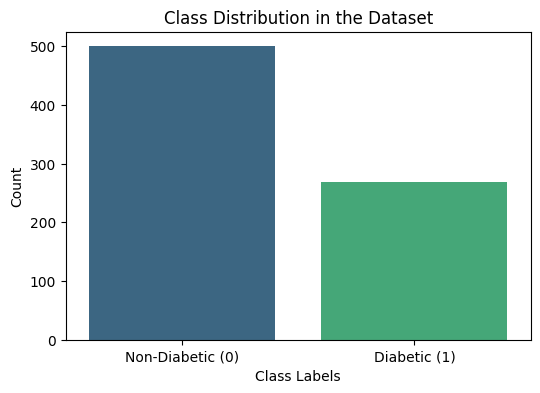

In [6]:
# Visualizing class imbalance
plt.figure(figsize=(6,4))
sns.barplot(x=df["Outcome"].value_counts().index, y=df["Outcome"].value_counts().values, palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution in the Dataset")
plt.xticks([0,1], labels=["Non-Diabetic (0)", "Diabetic (1)"])
plt.show()

In [7]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Baseline Model

In [9]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_roc_auc = roc_auc_score(y_test, y_pred)

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline ROC AUC Score: {baseline_roc_auc:.4f}")

# Store results
results = {"Baseline": {"Accuracy": baseline_accuracy, "ROC AUC": baseline_roc_auc}}

Baseline Accuracy: 0.8150
Baseline ROC AUC Score: 0.8145


### Manual Hyperparameter Tuning

In [10]:
# Train the model with some parameters
model = RandomForestClassifier(n_estimators=200,criterion='entropy',
                             max_features='sqrt',min_samples_leaf=10, random_state=42).fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Accuracy: 0.78
ROC AUC Score: 0.7796779677967796


### Automated Hyperparameter tuning

#### Grid Search

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
results["GridSearch"] = {"Accuracy": accuracy_score(y_test, y_pred), "ROC AUC": roc_auc_score(y_test, y_pred)}
print(f"Best Params (Grid Search): {grid_search.best_params_}")

Best Params (Grid Search): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


#### Randomized Search

In [12]:
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': np.arange(2, 11, 2)
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, scoring='roc_auc')
random_search.fit(X_train, y_train)
y_pred = random_search.best_estimator_.predict(X_test)
results["RandomizedSearch"] = {"Accuracy": accuracy_score(y_test, y_pred), "ROC AUC": roc_auc_score(y_test, y_pred)}
print(f"Best Params (Randomized Search): {random_search.best_params_}")

Best Params (Randomized Search): {'n_estimators': 250, 'min_samples_split': 6, 'max_depth': 30}


#### Bayesian Optimization (Hyperopt)

In [13]:
def objective(params):
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {'loss': -roc_auc_score(y_test, y_pred), 'status': 'ok'}

space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 150, 200, 250]),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]),
    'min_samples_split': hp.choice('min_samples_split', [2, 4, 6, 8, 10])  # Corrected this
}

trials = Trials()
best_params_idx = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

best_params = {
    'n_estimators': [50, 100, 150, 200, 250][best_params_idx['n_estimators']],
    'max_depth': [None, 10, 20, 30][best_params_idx['max_depth']],
    'min_samples_split': [2, 4, 6, 8, 10][best_params_idx['min_samples_split']]
}

best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

results["Hyperopt"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_pred)
}

print(f"Best Params (Hyperopt): {best_params}")

100%|███████████████████████████████████████████████| 10/10 [00:02<00:00,  4.93trial/s, best loss: -0.8095809580958095]
Best Params (Hyperopt): {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2}


#### Sequential Model-Based Optimization (Skopt)

In [14]:
skopt_search = BayesSearchCV(RandomForestClassifier(random_state=42), param_dist, n_iter=10, cv=3, n_jobs=-1, scoring='roc_auc')
skopt_search.fit(X_train, y_train)
y_pred = skopt_search.best_estimator_.predict(X_test)
results["Skopt"] = {"Accuracy": accuracy_score(y_test, y_pred), "ROC AUC": roc_auc_score(y_test, y_pred)}
print(f"Best Params (Skopt): {skopt_search.best_params_}")

Best Params (Skopt): OrderedDict({'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150})


#### Optuna Optimization

In [15]:
def optuna_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, 50),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, 2)
    }
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(optuna_objective, n_trials=10)
y_pred = RandomForestClassifier(**study.best_params, random_state=42).fit(X_train, y_train).predict(X_test)
results["Optuna"] = {"Accuracy": accuracy_score(y_test, y_pred), "ROC AUC": roc_auc_score(y_test, y_pred)}
print(f"Best Params (Optuna): {study.best_params}")

Best Params (Optuna): {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 6}


#### Genetic Algorithm (TPOT)

In [16]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
results["TPOT"] = {"Accuracy": accuracy_score(y_test, y_pred), "ROC AUC": roc_auc_score(y_test, y_pred)}
print(f"Best Pipeline (TPOT): {tpot.fitted_pipeline_}")

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8125

Generation 2 - Current best internal CV score: 0.8125

Generation 3 - Current best internal CV score: 0.8125

Generation 4 - Current best internal CV score: 0.8125

Generation 5 - Current best internal CV score: 0.8137500000000001

Best pipeline: ExtraTreesClassifier(CombineDFs(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=16, n_estimators=100), input_matrix), bootstrap=False, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=7, min_samples_split=10, n_estimators=100)
Best Pipeline (TPOT): Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('stackingestimator',
                                                 StackingEstimator(estimator=ExtraTreesClassifier(criterion='entropy',
                                                                                                  max_features=0.75

### Conclusion - Final results

In [17]:
print(results)

{'Baseline': {'Accuracy': 0.815, 'ROC AUC': 0.8145314531453145}, 'GridSearch': {'Accuracy': 0.815, 'ROC AUC': 0.8145314531453145}, 'RandomizedSearch': {'Accuracy': 0.785, 'ROC AUC': 0.7846284628462845}, 'Hyperopt': {'Accuracy': 0.81, 'ROC AUC': 0.8095809580958095}, 'Skopt': {'Accuracy': 0.81, 'ROC AUC': 0.8094809480948095}, 'Optuna': {'Accuracy': 0.795, 'ROC AUC': 0.7946294629462946}, 'TPOT': {'Accuracy': 0.8, 'ROC AUC': 0.7997799779977998}}
